# Inference

Test the trained and saved on model on the cropped Eilat images.

## Imports

In [1]:
# load custom scripts
from utils import *
import config 

# import the necessary packages
from imutils import paths
from PIL import Image
from skimage import io
from torchmetrics import ConfusionMatrix
from torchvision import transforms
import albumentations as A
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import torch
import torchmetrics

## Controlling sources of randomness

In [2]:
# Set seed
SEED = 42
seed_all(SEED)

## Padding images

In [3]:
def padd(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [4]:
# padd images

#scene = 'selected'
#imagePaths = sorted(list(paths.list_images('/data/jantina/data/CoralNet/inference/images/'+scene+'/')))

#for images in imagePaths:
    #im = Image.open(images)
    #im_new = padd(im, 12, 96, 0, 0, (0, 0, 0)) 
    #imagePath = '/data/jantina/data/CoralNet/inference/images_padded/'+scene+'/' + images.split(os.path.sep)[-1]
    #im_new.save(imagePath)

## Plot function

In [5]:
classes = {0: 'no label',
           1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: '(macro) algae',
           8: 'seagrass',
           9: 'unknown'
          }

In [6]:
cmap = mpl.colors.ListedColormap(['1',
                                  (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
                                  (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
                                  (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
                                  (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
                                  (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
                                  (0.8705882352941177, 0.6196078431372549, 0.8392156862745098),
                                  (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
                                  (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
                                  (0.6470588235294118, 0.3176470588235294, 0.5803921568627451)
                                 ])

## Testing loop

In [7]:
def make_predictions(model, imagePath, x_min, y_min, x_max, y_max):
    # set model to evaluation mode
    model.eval()
    
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk
        image = io.imread(imagePath)
        
        # load the labels from disk
        groundTruthPath = '/data/jantina/data/CoralNet/inference/labels/'+scene+ imagePath.split(os.path.sep)[-1]+'.tif'
        Label = io.imread(groundTruthPath)
        
        # add padding 
        gtLabel = np.zeros((512,896))
        gtLabel[12:512,:800] = Label
        
        # define transformation
        test_transform = A.Compose([
            A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max),    
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
    
        # apply transformation
        transformed = test_transform(image=image, mask=gtLabel)
        image = transformed["image"]
        gtLabel = transformed["mask"]
        
        # create image tensor
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image)
        image = image.to("cuda")
        
        # create mask tensor
        asarray = lambda x: torch.tensor(np.array(x), dtype=torch.long)
        gtLabel = asarray(np.expand_dims(gtLabel, 0))

        # prediction
        predLabel = model(image).squeeze()
        predLabel = torch.argmax(predLabel, dim=0)
        predLabel = predLabel.cpu()
        
    return image, gtLabel.squeeze(), predLabel    

## Make predictions

In [8]:
# initialize metrics
confmat = ConfusionMatrix(num_classes=10)
acc = torchmetrics.Accuracy(ignore_index=0)

In [9]:
x_min = [0, 128, 256, 384, 512, 640, 768]
x_max = [128, 256, 384, 512, 640, 768, 896]
y_min = [0, 128, 256, 384]
y_max = [128, 256, 384, 512]

In [10]:
scene = 'scene_3/'

In [11]:
# load the image paths corresponding to the images
print("[INFO] loading up test image paths...")
directory = '/data/jantina/data/CoralNet/inference/images_padded/'+scene

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load("/data/jantina/data/CoralNet/dataset/small/output/unet.pth").to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/medium/output/unet.pth").to(config.DEVICE)
#unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/output_dense/unet.pth").to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/output/unet2.pth").to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/output/weighted.pth").to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/output/eilat.pth").to(config.DEVICE)


conf = np.zeros((10,10)) 
totalaccu = 0
countacc = 0

for path in os.listdir(directory):        
    imagePath = os.path.join(directory, path)
    for i in range(7):
        for j in range(4):
            image, gtLabel, predLabel = make_predictions(unet, 
                                                         imagePath,
                                                         x_min[i], 
                                                         y_min[j], 
                                                         x_max[i], 
                                                         y_max[j])
            
            conf += np.array(confmat(predLabel, gtLabel.squeeze()))

            if torch.sum(gtLabel)!=0:
                countacc += 1
                totalaccu += acc(predLabel, gtLabel)

[INFO] loading up test image paths...
[INFO] load up model...


In [12]:
totalaccu/countacc

tensor(0.4543)

## Normalized Confusion Matrix

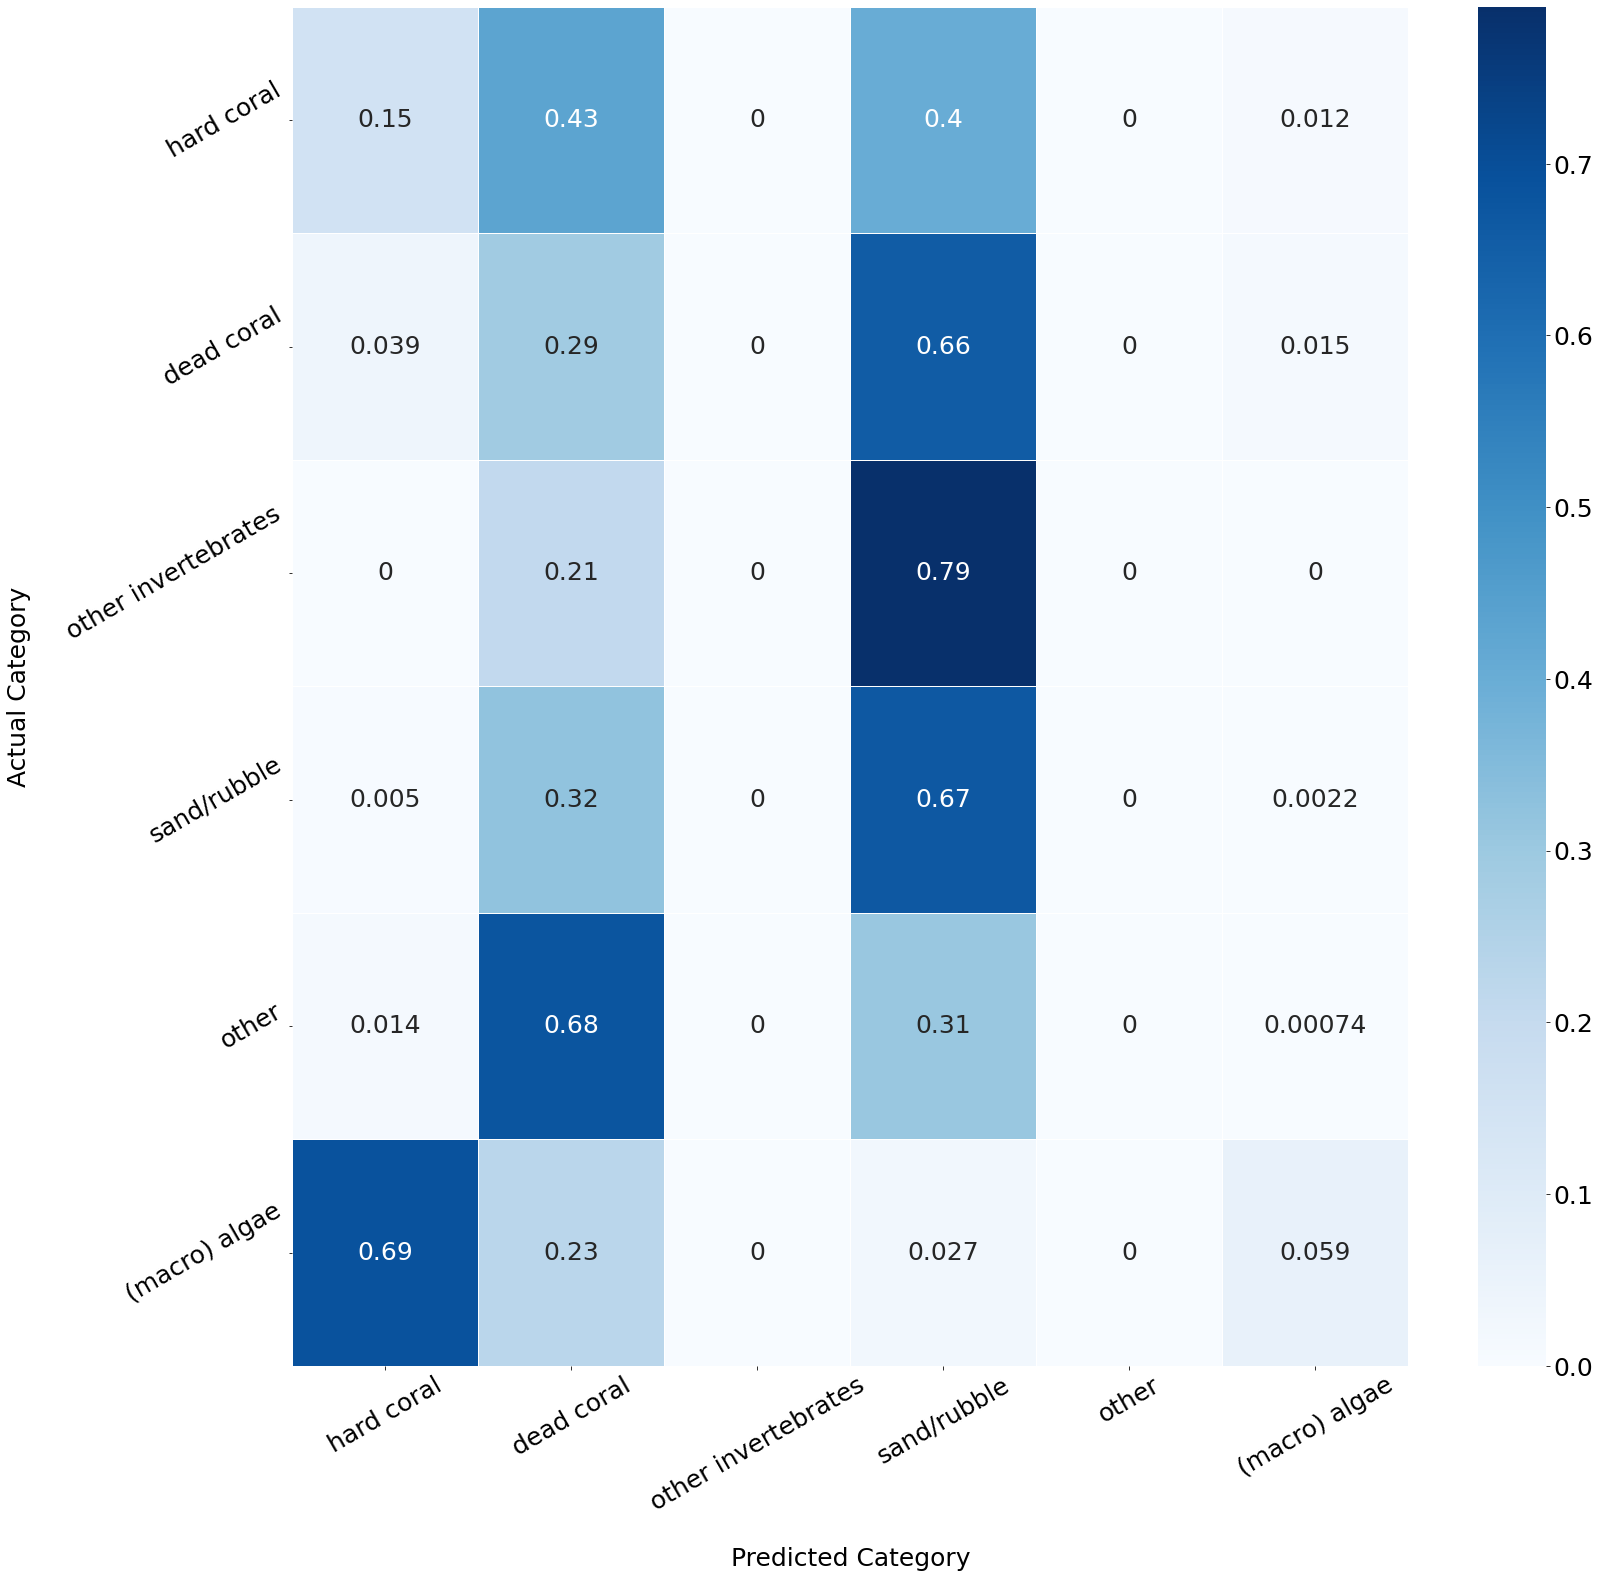

In [13]:
classes = {
           0: 'hard coral',
           1: 'dead coral',
           2: 'other invertebrates',
           3: 'sand/rubble',
           4: 'other',
           5: '(macro) algae',
          }

norm = np.copy(conf)

for i in range(len(conf)):
    if conf.sum(axis=1)[:, np.newaxis][i] != 0:
        norm[i,:] = conf[i,:] / conf.sum(axis=1)[:, np.newaxis][i]
   

norm = norm[1:, 1:]
norm = np.delete(norm, 1, 0)
norm = np.delete(norm, 1, 1)
norm = np.delete(norm, 6, 0)
norm = np.delete(norm, 6, 1)
norm = np.delete(norm, 6, 0)
norm = np.delete(norm, 6, 1)

# confusion matrix
fig, ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(norm, annot=True, cmap='Blues', linewidths=.5, ax=ax, annot_kws={"size": 25})

#ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category', fontsize = 25)
ax.set_ylabel('Actual Category\n ', fontsize = 25)

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=25)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(classes.values()),rotation = 30, fontsize = 25)
ax.yaxis.set_ticklabels(list(classes.values()),rotation = 30, fontsize = 25)

plt.savefig('eilat_confmat.pdf')  
plt.show()